# Primitives

A primitive is the lowest level operational that is useful to the user. An example of a qiskit primitive is an estimator primitive, which computes the expectation values of observables in a quantum circuit. A sampler primitive can give a bit string of some result of a quantum circuit.

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}^\dag$")

# Transverse field ising model

def generate_1d_ising_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits, trotter_barriers = False, layer_barriers = False):
    qc = QuantumCircuit(num_qubits, num_cl_bits)
    
    for t_step in range(num_trotter_steps):
        add_1d_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

    return qc


def add_1d_layer(qc, angle, layer_barriers = False):

    # adding Rzz gates in even layers
    for i in range(0, qc.num_qubits - 1, 2):
        qc.sdg([i, i + 1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()

    # adding Rzz gates in odd layers
    for i in range(1, qc.num_qubits - 1, 2):
        qc.sdg([i, i + 1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()

    qc.rx(angle, list(range(qc.num_qubits)))

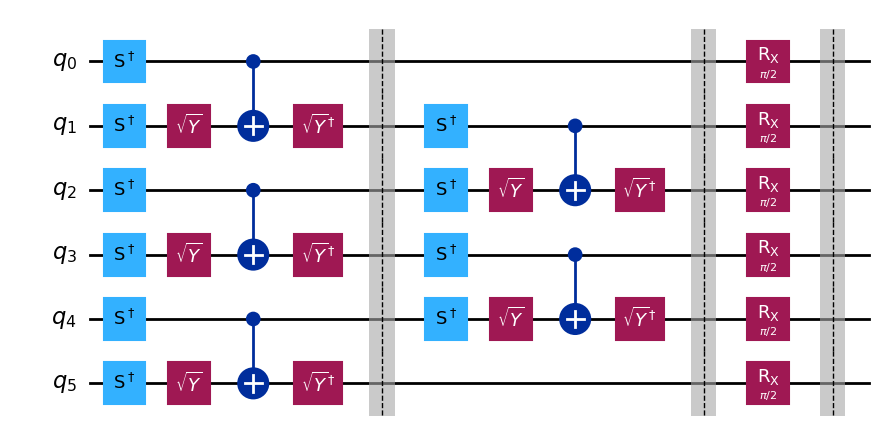

In [5]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi

qc = generate_1d_ising_circuit(num_qubits, num_trotter_steps, rx_angle, 0, True, True)
qc.draw('mpl', fold=1)

# Demo: Sampler

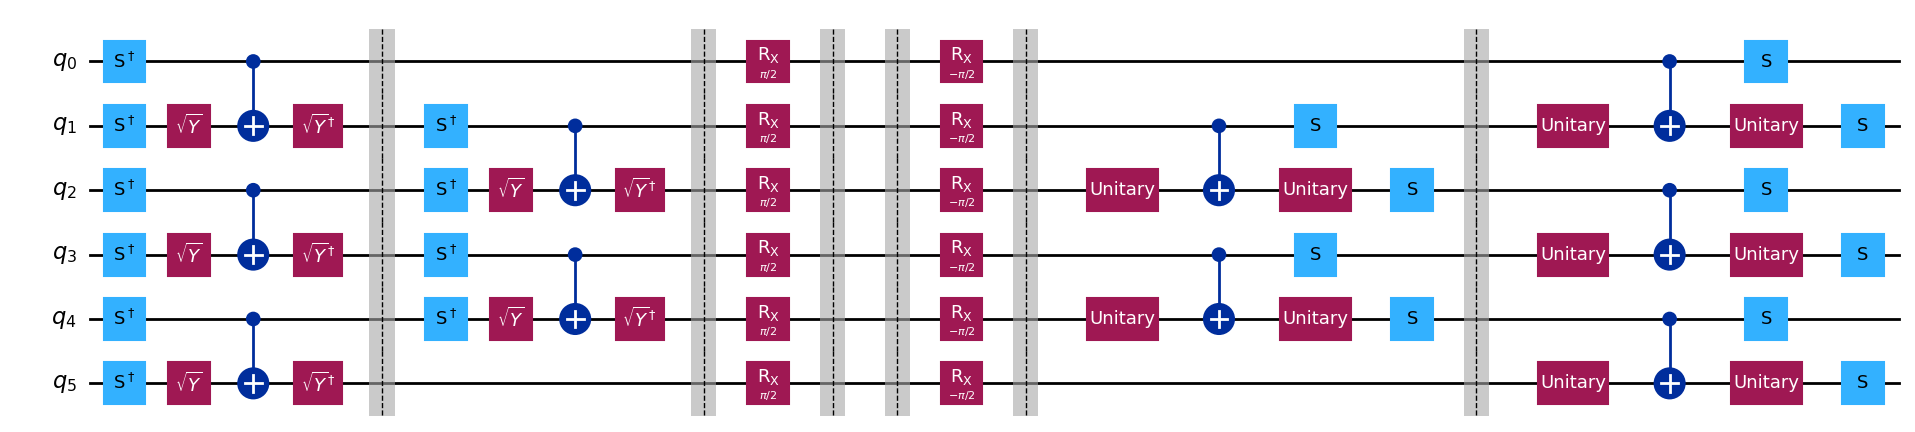

In [6]:
# create identity gate by &ing reversed circuit with circuit

def create_mirrored_circuit(qc1):
    return qc & qc.inverse()

new_qc = create_mirrored_circuit(qc)
new_qc.draw('mpl', fold=-1)

## Step 1 - Map problem to circuits and observables

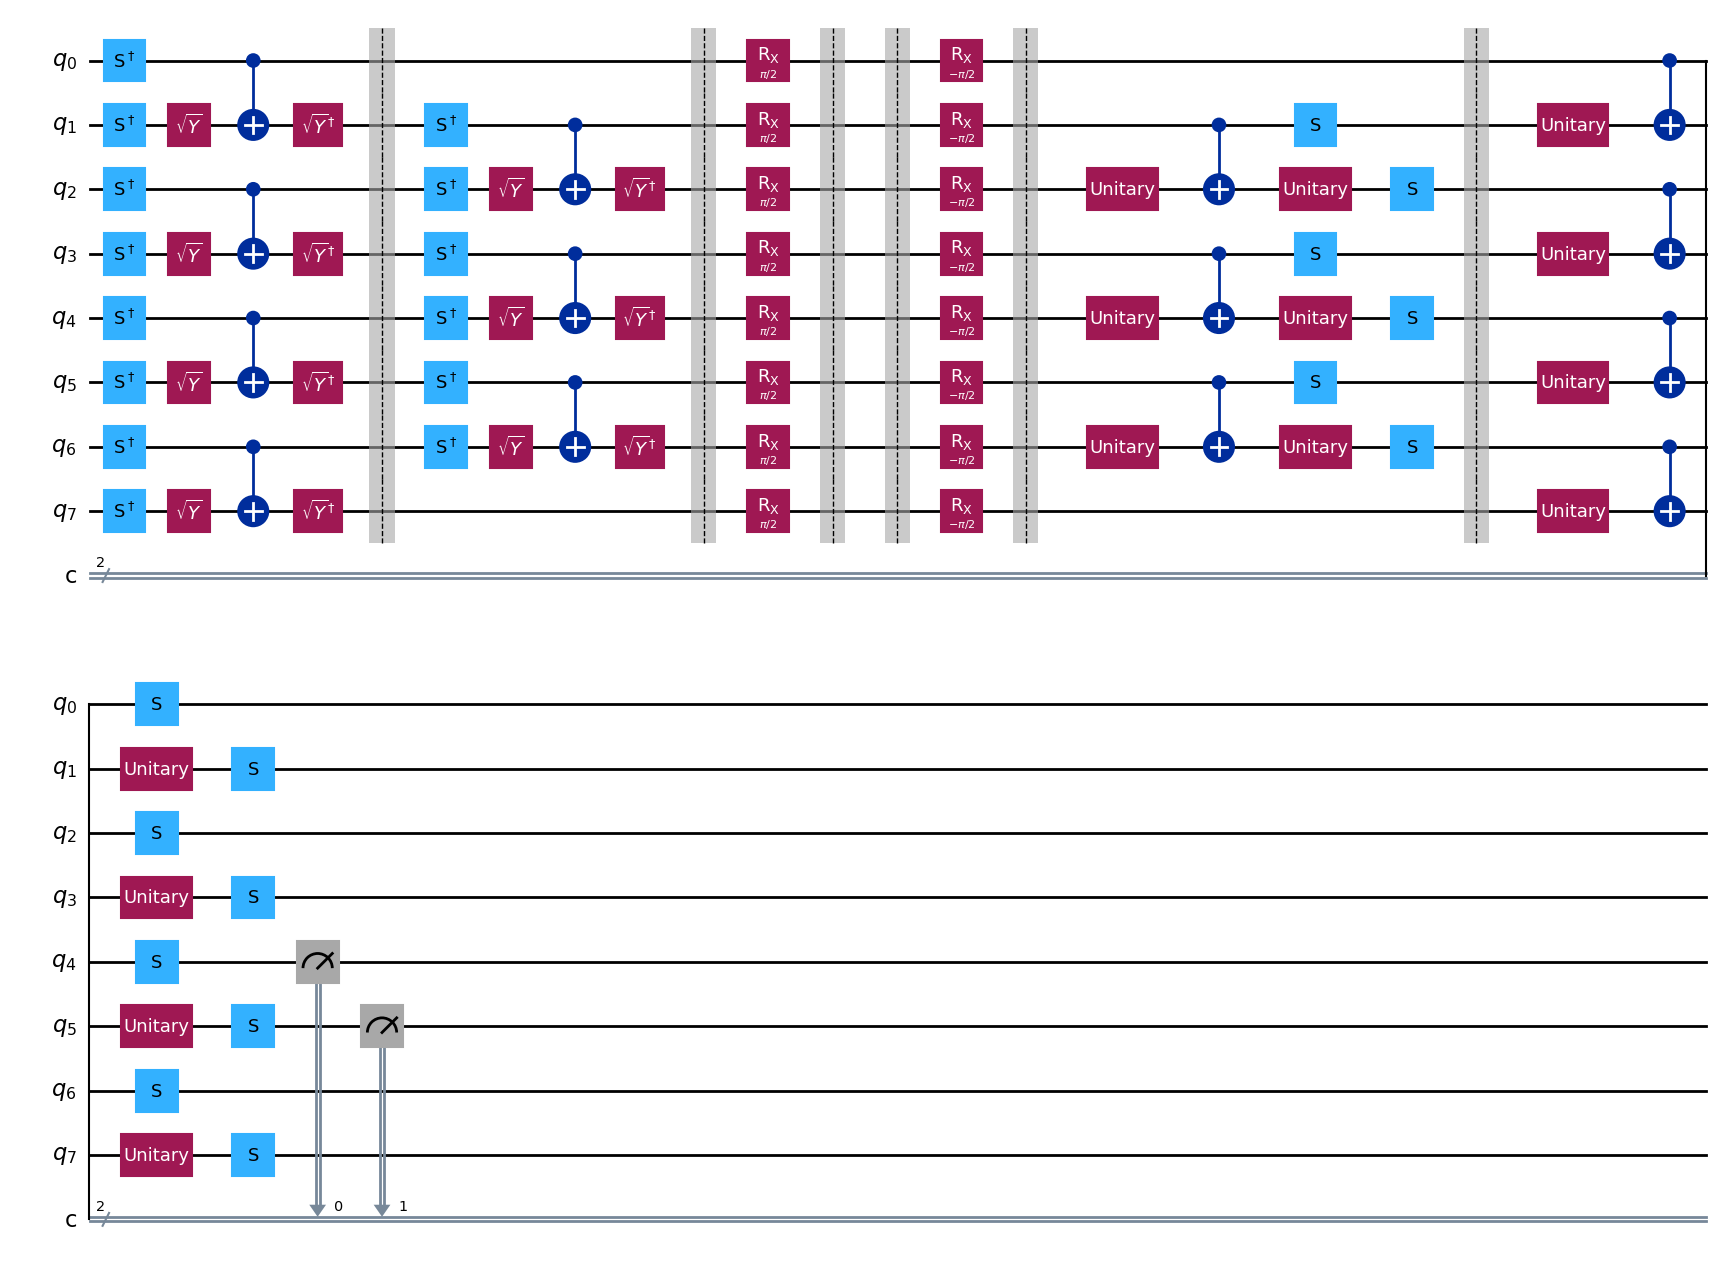

In [15]:
max_trotter_steps = 10
num_qubits = 8
measured_qubits = [4, 5]

qc_list = []
for t_step in range(max_trotter_steps):
    qc = generate_1d_ising_circuit(num_qubits, t_step, rx_angle, num_cl_bits=len(measured_qubits), trotter_barriers=True, layer_barriers=True)
    qc_mirrored = create_mirrored_circuit(qc)
    qc_mirrored.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc_mirrored)

qc_list[1].draw('mpl')